# Big Data Platforms - Final Project
### Analysis of University Tweets (Python Script)
### By Kyla Ronellenfitsch
### March 19, 2021

## Import Packages 

In [2]:
# Import relevant packages 
import os
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import re
import shutil
# import sh
from simhash import Simhash, SimhashIndex
import seaborn as sns
import datetime as dt
import nltk
from collections import Counter
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt')
import spacy 
from spacy import displacy
import difflib

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylaronellenfitsch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kylaronellenfitsch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Create Functions for Analysis

During the filtering process, csv files for each university were created. The following functions were created to expedite and standardize cleaning and analysis of each university's data. 

In [3]:
# Function to convert string time variables into datetime, and drop unnecessary columns. 

def date_change(df):
    df['date_tweet_created'] = df.tweet_created.str[4:10] #parse string column to extract tweet date
    df['time_tweet_created'] = df.tweet_created.str[11:19] #time
    df['year_tweet_created'] = df.tweet_created.str[26:] #year
    
    df['date_acct_created'] = df.created_at.str[4:10] #parse string column to extract account creation date
    df['time_acct_created'] = df.created_at.str[11:19] #time 
    df['year_acct_created'] = df.created_at.str[26:] #year
    
    df['tweet_created'] = (df['date_tweet_created'] + ' ' + df['year_tweet_created']) #combine date and year
    df['tweet_created'] = df['tweet_created'].str.replace(" ","-")
    
    df['acct_created'] = (df['date_acct_created'] + ' ' + df['year_acct_created']) #combine date and year
    df['acct_created'] = df['acct_created'].str.replace(" ","-")
    
    df = df.drop(columns=['Unnamed: 0', #original index variable
                          'created_at', #date tweet was creeated 
                          'lang', #omit language since already used to filter English tweets
                          'retweet_count', #retweet count was mostly null
                          'favorite_count', #favourite count was mostly null
                          'following', #following count was mostly null
                          'filter_level', #all filter levels were 'low'
                          'date_tweet_created', #omit previously constructed date variables 
                          'year_tweet_created',
                          'date_acct_created',
                          'year_acct_created'])
    
    #ensure new tweet_created/acct_created variables fit format 
    months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

    df = df[df['tweet_created'].str.len() == 11]
    df = df[df['tweet_created'].str.startswith(months)]
    df['tweet_created'] = pd.to_datetime(df['tweet_created'])
    
    df = df[df['acct_created'].str.len() == 11]
    df = df[df['acct_created'].str.startswith(months)]
    df['acct_created'] = pd.to_datetime(df['acct_created'])
    
    
    df = df.sort_values(by='tweet_created')
    
    return(df)

In [4]:
# Create new location variable 
def new_location(df):
    #Separate individual elements of original location variable 
    df['location2'] = df['location'].str.partition(',')[0] #in most cases, identification of city
    df['location3'] = df['location'].str.partition(',')[2] #in most cases, identification of state or country
    
    #Standardize names of common locations across all 4 datasets 
    df.loc[df['location2'].str.contains("Chicago", na=False), 'location2'] = 'Chicago'
    df.loc[df['location2'].str.contains("chicago", na=False), 'location2'] = 'Chicago'
    df.loc[df['location2'].str.contains("Hyde Park", na=False), 'location2'] = 'Chicago'
    df.loc[df['location2'].str.contains("USA", na=False), 'location2'] = 'United States'
    df.loc[df['location2'].str.contains("New York", na=False), 'location2'] = 'New York'
    df.loc[df['location2'].str.contains("NYC", na=False), 'location2'] = 'New York'
    
    return(df)

In [5]:
# Create new variables necessary for analysis 
def new_vars(df):
    
    #used for later aggregation 
    df['tweet'] = 1 
    
    #identify retweets based on inclusion of "RT" in tweet 
    df['retweet'] = df['text'].map(lambda x: True if 'RT' in str(x) else False)
    
    #identify duplicate tweets
    df['duplicate_tweet'] = df.duplicated(subset='text')
    
    return(df)

In [6]:
# Create a new dataframe, which includes details about each individual Twitterer
def unique_vars(df):
    unique_df = df[['description', #blurb included in profile
             'favourites_count', #number of favourited tweets
             'followers_count', #number of followers
             'friends_count', #number of friends
             'screen_name', #Twitter handle
             'acct_created', #date account created
             'location2', #primary location
             'verified', #whether/not they are a verified account
             'statuses_count']] #number of tweets/retweets 
    # Used last record for each Twitterer, allowing for most up-to-date information 
    unique_df = unique_df.drop_duplicates(subset='screen_name', keep='last')
    # return new dataframe
    return(unique_df)

In [7]:
# Create dataframe that aggregates the number of Twitterers living in each location 
def location_sum(df):
    # use previously created 'unique' variable to avoid double counting 
    # identify unique locations and return counts 
    location = pd.DataFrame(np.unique(df['location2'].astype(str), return_counts=True)).T.sort_values(by=1, ascending=False)
    # rename columns 
    location = location.rename(columns={0:'Location', 1:'Count'})
    # create percentage column 
    location['percentage'] = location['Count']/len(df)*100
    # set location as index 
    location = location.set_index('Location')
    
    #return new dataframe 
    return(location)

In [8]:
# Create new dataframe that aggregates tweets for each individual Twitterer 
def tweeters(df, unique_df):
    # count total university-related tweets for each Twitterer 
    tweeter_df = pd.DataFrame(np.unique(df['screen_name'].astype(str), return_counts=True)).T.sort_values(by=1, ascending=False)
    # rename coolumns
    tweeter_df = tweeter_df.rename(columns={0:'screen_name', 1:'num_tweets'}).set_index('screen_name')
    
    #retrieve latest count of number of tweets/retweets for each Twitterer
    all_tweets = unique_df[['screen_name','statuses_count']].set_index('screen_name').sort_values(by='statuses_count', ascending=False)
    
    # combine number of uni-related tweets and all tweets into one dataframe
    all_tweets = tweeter_df.join(all_tweets)
    # create percentage column
    all_tweets['percentage'] = (all_tweets['num_tweets']/all_tweets['statuses_count'])*100
    
    # convert to float 
    all_tweets = all_tweets.astype('float')
    
    #return new dataframe
    return(all_tweets)

In [9]:
# update previously created 'unique' dataframe with addition of tweet activity 
def join_unique(tweeter_df, unique_df):
    #set 'unique' dataframe's index as screen name
    unique = unique_df.set_index('screen_name')
    #join with tweeter_df
    unique = unique.join(tweeter_df[['num_tweets','percentage']], how='left')
    
    #return new 'unique' dataframe
    return(unique)

In [10]:
# create summary dataframe with time aggregated to monthly
def tweet_month(df):
    # convert 'tweet created' variable
    df['tweet_month'] = pd.to_datetime(df.tweet_created).dt.strftime('%m/%Y')
    # group number of tweets based on month 
    month = df.groupby('tweet_month').sum('tweet')
    # select number of tweets only 
    month = pd.DataFrame(month['tweet'])
    
    # return new dataframe
    return(month)

In [11]:
# Create visualizations for Twitterers' tweet activity and reach 
def box_plots(unique_df):
    f, axes = plt.subplots(4, 1)
    sns.boxplot(x="favourites_count", data=unique_df, ax=axes[0])
    sns.boxplot(x="followers_count", data=unique_df, ax=axes[1])
    sns.boxplot(x="friends_count", data=unique_df, ax=axes[2])
    sns.boxplot(x="statuses_count", data=unique_df, ax=axes[3])
    f.set_size_inches(4, 16)

In [174]:
# Create dataframe of 'prolific twitterers'
def prolific(unique_df):
    prolific_df = unique_df[(unique_df['verified']==True)| #those who are verified users OR
                            (unique_df['statuses_count'] >= 50000)| #have >= 50000 tweets/retweets OR
                            (unique_df['followers_count'] >= 10000)] #have >= 10000 followers
    
    prolific_df['percentage'] = prolific_df['percentage'].round(1)
    
    return(prolific_df)

## University of Chicago Analysis 

In [12]:
#read in data 
uchicago_df = pd.read_csv('shared_data_kmr1_uchicago_df')

In [13]:
## change date, drop unnecessary columns 
uchicago_df = date_change(uchicago_df)
uchicago_df.head()

,tweet_created,text,statuses_count,quoted_status_id_str,default_profile_image,description,favourites_count,followers_count,friends_count,id_str,screen_name,location,time_zone,verified,time_tweet_created,time_acct_created,acct_created
540380,2017-06-22,RT @HdxAcademy: We congratulate @UChicago &amp...,101,NaN,False,"Author, blogger, mother, seeker. http://elizab...",225.0,33.0,463.0,8.156170e+17,NewMetaphor00,United States,NaN,False,23:36:01,17:53:34,2017-01-01
210694,2017-06-22,Tempus and University of Chicago Medicine Coll...,1320307,NaN,False,Find all financials news in real time. Equitie...,284.0,8260.0,79.0,1.023252e+08,ForTraders,NaN,Eastern Time (US & Canada),False,14:31:04,09:33:43,2010-01-06
210693,2017-06-22,@cblatts @UChicago check out your professor. B...,119,NaN,False,Ruff Ryda,335.0,6.0,57.0,7.898316e+17,Bongodingo123,"North West, England",NaN,False,14:29:15,14:11:38,2016-10-22
210692,2017-06-22,RT @atbrooks: ALA conference attendees invited...,2676,NaN,False,Crerar Library is the Science and Medicine Lib...,1363.0,828.0,289.0,2.476624e+07,CrerarLibrary,Chicago,Central Time (US & Canada),False,14:17:34,20:47:35,2009-03-16
210691,2017-06-22,RT @polskycenter: UChicago/AbbVie partnership ...,289,NaN,False,We're a research center leading the way in #da...,251.0,124.0,154.0,7.391141e+17,UChicagoCDIS,"Chicago, IL",NaN,False,14:16:56,15:18:25,2016-06-04


In [14]:
# clean location variable
uchicago_df = new_location(uchicago_df)
uchicago_df.head()

,tweet_created,text,statuses_count,quoted_status_id_str,default_profile_image,description,favourites_count,followers_count,friends_count,id_str,screen_name,location,time_zone,verified,time_tweet_created,time_acct_created,acct_created,location2,location3
540380,2017-06-22,RT @HdxAcademy: We congratulate @UChicago &amp...,101,NaN,False,"Author, blogger, mother, seeker. http://elizab...",225.0,33.0,463.0,8.156170e+17,NewMetaphor00,United States,NaN,False,23:36:01,17:53:34,2017-01-01,United States,
210694,2017-06-22,Tempus and University of Chicago Medicine Coll...,1320307,NaN,False,Find all financials news in real time. Equitie...,284.0,8260.0,79.0,1.023252e+08,ForTraders,NaN,Eastern Time (US & Canada),False,14:31:04,09:33:43,2010-01-06,NaN,NaN
210693,2017-06-22,@cblatts @UChicago check out your professor. B...,119,NaN,False,Ruff Ryda,335.0,6.0,57.0,7.898316e+17,Bongodingo123,"North West, England",NaN,False,14:29:15,14:11:38,2016-10-22,North West,England
210692,2017-06-22,RT @atbrooks: ALA conference attendees invited...,2676,NaN,False,Crerar Library is the Science and Medicine Lib...,1363.0,828.0,289.0,2.476624e+07,CrerarLibrary,Chicago,Central Time (US & Canada),False,14:17:34,20:47:35,2009-03-16,Chicago,
210691,2017-06-22,RT @polskycenter: UChicago/AbbVie partnership ...,289,NaN,False,We're a research center leading the way in #da...,251.0,124.0,154.0,7.391141e+17,UChicagoCDIS,"Chicago, IL",NaN,False,14:16:56,15:18:25,2016-06-04,Chicago,IL


In [15]:
# inspect cleaned location column 
pd.DataFrame(np.unique(uchicago_df['location2'].astype(str), return_counts=True)).T.sort_values(by=1, ascending=False).head(25)

,0,1
44169,nan,179512
8443,Chicago,103175
36367,United States,13733
23936,New York,11006
37590,Washington,6888
20175,Los Angeles,3912
19931,London,3112
7429,California,2926
16270,Illinois,2851
6324,Boston,2370


In [16]:
# create new variables for analysis 
uchicago_df = new_vars(uchicago_df)
uchicago_df.head()

,tweet_created,text,statuses_count,quoted_status_id_str,default_profile_image,description,favourites_count,followers_count,friends_count,id_str,...,time_zone,verified,time_tweet_created,time_acct_created,acct_created,location2,location3,tweet,retweet,duplicate_tweet
540380,2017-06-22,RT @HdxAcademy: We congratulate @UChicago &amp...,101,NaN,False,"Author, blogger, mother, seeker. http://elizab...",225.0,33.0,463.0,8.156170e+17,...,NaN,False,23:36:01,17:53:34,2017-01-01,United States,,1,True,False
210694,2017-06-22,Tempus and University of Chicago Medicine Coll...,1320307,NaN,False,Find all financials news in real time. Equitie...,284.0,8260.0,79.0,1.023252e+08,...,Eastern Time (US & Canada),False,14:31:04,09:33:43,2010-01-06,NaN,NaN,1,False,False
210693,2017-06-22,@cblatts @UChicago check out your professor. B...,119,NaN,False,Ruff Ryda,335.0,6.0,57.0,7.898316e+17,...,NaN,False,14:29:15,14:11:38,2016-10-22,North West,England,1,False,False
210692,2017-06-22,RT @atbrooks: ALA conference attendees invited...,2676,NaN,False,Crerar Library is the Science and Medicine Lib...,1363.0,828.0,289.0,2.476624e+07,...,Central Time (US & Canada),False,14:17:34,20:47:35,2009-03-16,Chicago,,1,True,False
210691,2017-06-22,RT @polskycenter: UChicago/AbbVie partnership ...,289,NaN,False,We're a research center leading the way in #da...,251.0,124.0,154.0,7.391141e+17,...,NaN,False,14:16:56,15:18:25,2016-06-04,Chicago,IL,1,True,False


In [17]:
print("Number of Tweets about UChicago = {}".format(len(uchicago_df)))

Number of Tweets about UChicago = 571001


In [18]:
# create new dataframe summarizing each twitterers' account
uchicago_unique = unique_vars(uchicago_df)
uchicago_unique.head()

,description,favourites_count,followers_count,friends_count,screen_name,acct_created,location2,verified,statuses_count
540380,"Author, blogger, mother, seeker. http://elizab...",225.0,33.0,463.0,NewMetaphor00,2017-01-01,United States,False,101
210693,Ruff Ryda,335.0,6.0,57.0,Bongodingo123,2016-10-22,North West,False,119
380095,Work hard. Live long. Plan right. Financial Co...,19.0,525.0,477.0,CrimminsWM,2011-07-26,Bergen County,False,1139
380094,NaN,77.0,64.0,339.0,PReaumond,2015-10-15,NaN,False,92
353051,"Passionate public librarian. Service, communit...",18245.0,882.0,714.0,wrk2lib,2016-05-03,Massachusetts,False,16790


In [19]:
# Create summary location table 
uchicago_location = location_sum(uchicago_unique)
uchicago_location.head()

,Count,percentage
Location,,
nan,86662,30.8752
Chicago,18699,6.66192
United States,7038,2.50744
New York,5685,2.0254
Washington,3351,1.19387


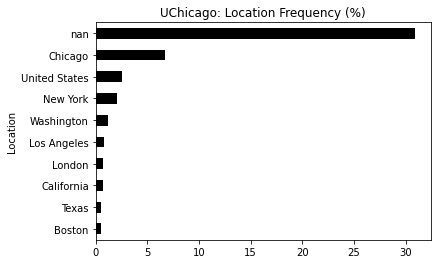

In [20]:
# Visualize location distribution for UChicago Twitterers
ax = uchicago_location['percentage'].head(10).sort_values(ascending=True).plot.barh(color='black', title='UChicago: Location Frequency (%)');
ax.grid(False)

In [21]:
# Create summary table of Twitterers' tweet activity. Note most active accounts are from UChicago 
uchicago_tweeters = tweeters(uchicago_df, uchicago_unique)
uchicago_tweeters.head(20)

,num_tweets,statuses_count,percentage
screen_name,,,
nan,41239.0,NaN,NaN
UChicago,2705.0,21260.0,12.723424
uchicagogsu,2332.0,10419.0,22.382186
UChicagoMedJobs,2183.0,492.0,443.699187
ruthpaget,1408.0,48080.0,2.928453
LyoLouisJacques,995.0,18230.0,5.458036
ChicagoMaroons,978.0,10604.0,9.222935
UChiEngagement,921.0,8993.0,10.241299
UChicagoCollege,826.0,6415.0,12.876072


In [22]:
#update 'unique' dataframe with addition of tweet activity 
uchicago_unique = join_unique(uchicago_tweeters, uchicago_unique)
uchicago_unique.head()

,description,favourites_count,followers_count,friends_count,acct_created,location2,verified,statuses_count,num_tweets,percentage
screen_name,,,,,,,,,,
NewMetaphor00,"Author, blogger, mother, seeker. http://elizab...",225.0,33.0,463.0,2017-01-01,United States,False,101,1.0,0.990099
Bongodingo123,Ruff Ryda,335.0,6.0,57.0,2016-10-22,North West,False,119,1.0,0.840336
CrimminsWM,Work hard. Live long. Plan right. Financial Co...,19.0,525.0,477.0,2011-07-26,Bergen County,False,1139,1.0,0.087796
PReaumond,NaN,77.0,64.0,339.0,2015-10-15,NaN,False,92,1.0,1.086957
wrk2lib,"Passionate public librarian. Service, communit...",18245.0,882.0,714.0,2016-05-03,Massachusetts,False,16790,1.0,0.005956


In [23]:
print("Number of individuals Tweeting about UChicago = {}".format(len(uchicago_unique)))

Number of individuals Tweeting about UChicago = 280685


In [24]:
#show timezones 
pd.DataFrame(np.unique(uchicago_df['time_zone'].astype(str), return_counts=True)).T.sort_values(by=1, ascending=False)[:10]

,0,1
215,nan,496179
88,Central Time (US & Canada),21458
172,Pacific Time (US & Canada),20361
96,Eastern Time (US & Canada),14161
161,Mountain Time (US & Canada),2619
59,Atlantic Time (Canada),1830
179,Quito,1645
149,London,1457
39,Arizona,741
166,New Delhi,631


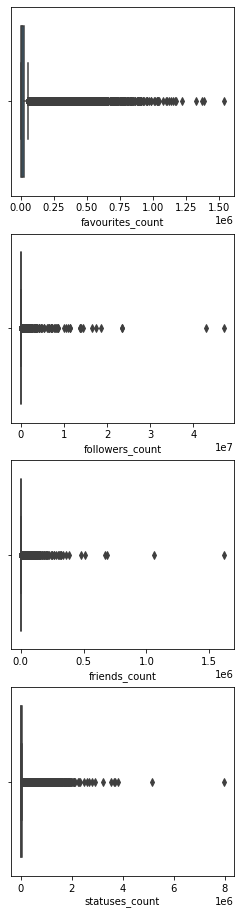

In [25]:
# highlight users' activity. Note most Twitterers' are not very active or widely followed 
box_plots(uchicago_unique)

In [26]:
# show number of verified users
pd.DataFrame(np.unique(uchicago_unique['verified'].astype(bool), return_counts=True)).T.sort_values(by=1, ascending=False)

,0,1
0,False,275034
1,True,5651


In [27]:
print("Percentage of verified accounts = {}%".format(5567/len(uchicago_unique)*100))

Percentage of verified accounts = 1.9833621319272492%


In [28]:
# EDA for tweet activity 
print("Median number of favourites = {}".format(uchicago_unique['favourites_count'].median()))
print("Median number of followers = {}".format(uchicago_unique['followers_count'].median()))
print("Median number of tweets = {}".format(uchicago_unique['statuses_count'].median()))

Median number of favourites = 5325.0
Median number of followers = 358.0
Median number of tweets = 6506.0


In [30]:
# Calculate percentage of tweets that are retweets 
uchicago_retweets = pd.DataFrame(np.unique(uchicago_df['retweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
uchicago_retweets = uchicago_retweets.rename(columns={0:'Retweet', 1:'Count'})
uchicago_retweets['percentage'] = uchicago_retweets['Count']/len(uchicago_df)*100
uchicago_retweets = uchicago_retweets.set_index('Retweet')
uchicago_retweets

,Count,percentage
Retweet,,
True,373620,65.4325
False,197381,34.5675


In [31]:
# Calculate number of tweets that are duplicates 
uchicago_dup = pd.DataFrame(np.unique(uchicago_df['duplicate_tweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
uchicago_dup = uchicago_dup.rename(columns={0:'Duplicate', 1:'Count'})
uchicago_dup['percentage'] = uchicago_dup['Count']/len(uchicago_df)*100
uchicago_dup = uchicago_dup.set_index('Duplicate')
uchicago_dup

,Count,percentage
Duplicate,,
True,318824,55.836
False,252177,44.164


In [176]:
# identify prolific twitterers, show those who tweet about UChicago most frequently
uchicago_prolific = prolific(uchicago_unique)
print(len(uchicago_prolific))
print(len(uchicago_prolific)/len(uchicago_unique))
pd.DataFrame(uchicago_prolific[['num_tweets', 'statuses_count', 'percentage']]).sort_values(by='num_tweets', ascending=False)[:20]

49672
0.17696706272155618


/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_tweets,statuses_count,percentage
screen_name,,,
UChicago,2705.0,21260,12.7
UChicagoMed,669.0,14875,4.5
HarrisPolicy,619.0,15254,4.1
shazrasul,609.0,53546,1.1
spark_radio_net,525.0,166738,0.3
nuclear94,410.0,430422,0.1
SmartUChicago,399.0,7069,5.6
haileysecretary,367.0,1829202,0.0
pstanpolitics,367.0,381,96.3


### Northwestern Analysis

The process for cleaning and analyzing data for Northwestern University was much the same as for UChicago, but with one major difference. It was understood that the university is commonly called "Northwestern", so this was one of the filter terms used. Of course, this is also used in many other contexts, so Named Entity Recognition was completed to assist with further filtering. 

In [40]:
# read in northwestern data 
northwestern_df = pd.read_csv('shared_data_kmr1_northwestern_df')

In [41]:
# convert date, omit unnecessary variables 
northwestern_df = date_change(northwestern_df)
# clean up location variable 
northwestern_df = new_location(northwestern_df)
# create new variables 
northwestern_df = new_vars(northwestern_df)

In [42]:
# number of cases at this juncture 
len(northwestern_df)

2111346

In [43]:
# create sample for NER 
nw_sample = northwestern_df.sample(10000, random_state=1)

In [44]:
# import spacy text library 
nlp = spacy.load("en_core_web_md")

In [45]:
# Conduct Named Entity Recognition (NER)
entities = []
labels = []

for i in nw_sample['text'].tolist():
    doc = nlp(i)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        
# Total of 30949 entities extracted from article text 
len(entities)

30949

In [46]:
# Save output as dataframe
ner_df = pd.DataFrame({'Entities':entities,'Labels':labels})
ner_df

,Entities,Labels
0,Budzien Northwestern,LOC
1,Kev,PERSON
2,Somalia,GPE
3,four,CARDINAL
4,@MorseCode206 Northwestern,ORG
...,...,...
30944,RT,ORG
30945,Tahrir,GPE
30946,Al-Sham's Chemical Stockpile,ORG
30947,RT,ORG


In [47]:
# summarize the different categories identified 
categories = pd.DataFrame(np.unique(ner_df['Labels'], return_counts=True)).T.sort_values(by=1, ascending=False)
categories

,0,1
11,ORG,10777
4,GPE,4830
13,PERSON,3247
9,NORP,3037
0,CARDINAL,2652
1,DATE,2243
7,LOC,1013
16,TIME,828
8,MONEY,526
10,ORDINAL,464


In [48]:
# select only entity types that will be useful for analysis 
entities = ner_df[ner_df.Labels.isin(['ORG','GPE','LOC','PERSON','NORP','PRODUCT','WORK_OF_ART','EVENT'])]
entities['Total'] = 1
# aggregate named entities, show 50 most common 
entities = entities.groupby(['Entities']).sum('Total').sort_values(by='Total', ascending=False)
entities.head(50)

/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Total
Entities,
RT,3882
Northwestern,3062
Northwestern University,357
Syria,197
Northwestern State,157
Michigan,139
Chicago,134
Wisconsin,131
Iowa,111


In [49]:
pd.set_option('display.max_colwidth', 650)

In [50]:
# at this point, most common terms were manually explored to understand relevance to NorthwesternU
nw_sample[nw_sample['text'].str.contains("Pat Fitzgerald")]['text'][:10]

167302     RT @Matt_Fortuna: Northwestern and Pat Fitzgerald are finalizing a 10-year extension through 2030, source tells @TheAthleticCFB. One less t…
1158202                     WATCH: Pat Fitzgerald gave emotional, motivational post-game speech after Northwestern won the West https://t.co/iYHterQszz
170241     RT @mitchsherman: Real talk from Northwestern coach Pat Fitzgerald on coaches who do everything within the rules to keep tabs on their recr…
781981     RT @SBN_BillC: Northwestern, Big Ten West champ. How the hell did Pat Fitzgerald’s *worst damn team in 7 years* pull this off? https://t.co…
736156     RT @AdamSchefter: Multiple NFL teams have inquired about Northwestern HC Pat Fitzgerald and, to date, as of right now, he has not agreed to…
13158                        I have never seen 1 player handicap his team like Payton Ramsey has Northwestern. Pat Fitzgerald has to be beside himself.
1068248           RT @thecoachtube: Northwestern football coach Pat Fitzgerald speaks on

In [51]:
# Note many mentions related to the conflict in Syria and Turkey
nw_sample[nw_sample['text'].str.contains("Turkish")]['text'][:10]

712799     RT @Reuters: Five Turkish soldiers were killed in northwestern Syria as fighting between Syrian government troops and Turkish forces flared…
1818851     Syria: Turkish military forces stationed at the Sher Mughar observation post in northwestern Hama are preparing to… https://t.co/3OFwapXZ8F
1056665                             Video: Turkish Military Intervention in Northwestern Syria. Troops and Vehicles Enter Idlib https://t.co/GAo8Ingypz
834941     RT @dersi4m: Update: In these minutes the Turkish army is shelling the northwestern neighbourhoods of #Qamishlo city (ANHA) #TwitterKurds h…
344131     RT @KenRoth: Turkish-backed Syrian rebels have a poor record in their treatment of Kurdish civilians in northwestern Syria: @HRW report. No…
1628440    RT @cnni: Turkish President Recep Tayyip Erdogan has said that 80,000 refugees escaping violence in northwestern Syria are heading to the T…
1247592                                           RT @GZeroConspiracy: Damascus blasts T

In [52]:
# identification of relevant words
nw_words = ['Northwestern University',
            'Chicago',
            'Evanston',
            'Illinois',
            'NorthwesternU',
            'Wildcats',
            'NCAA',
            'Pat Fitzgerald', 
            'Ohio State',
            'Big Ten',
            'Indiana',
            'Michigan',
            'Nebraska',
            'Rutgers',
            '@ESPNCFB',
            'Oklahoma',
            'Joseph Epstein',
            'Texas',
            'Maryland',
            'Notre Dame',
            'ESPN',
            'Kentucky',
            'PhD',
            'Purdue',
            'Penn', 
            'Utah',
            'student',
            'graduate',
            'faculty',
            'program',
            'study',
            'studies']

In [53]:
# filter out relevant records for final dataframe 
mask = northwestern_df['text'].apply(lambda x: any(item for item in nw_words if item in x))
northwestern_df = northwestern_df[mask]

In [54]:
# Show number of relevant tweets 
print("Number of Tweets about Northwestern = {}".format(len(northwestern_df)))

Number of Tweets about Northwestern = 676470


In [55]:
# Calculate number/percentage of retweets 
northwestern_retweets = pd.DataFrame(np.unique(northwestern_df['retweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
northwestern_retweets = northwestern_retweets.rename(columns={0:'Retweet', 1:'Count'})
northwestern_retweets['percentage'] = northwestern_retweets['Count']/len(northwestern_df)*100
northwestern_retweets = northwestern_retweets.set_index('Retweet')
northwestern_retweets

,Count,percentage
Retweet,,
True,389278,57.5455
False,287192,42.4545


In [56]:
# Calculate number/percentage of duplicates 
northwestern_dup = pd.DataFrame(np.unique(northwestern_df['duplicate_tweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
northwestern_dup = northwestern_dup.rename(columns={0:'Duplicate', 1:'Count'})
northwestern_dup['percentage'] = northwestern_dup['Count']/len(northwestern_df)*100
northwestern_dup = northwestern_dup.set_index('Duplicate')
northwestern_dup

,Count,percentage
Duplicate,,
False,342675,50.6563
True,333795,49.3437


In [57]:
# Create dataframe for unique twitterers 
unique_northwestern = unique_vars(northwestern_df)
unique_northwestern.head()

,description,favourites_count,followers_count,friends_count,screen_name,acct_created,location2,verified,statuses_count
962834,"Be who you are, Life is too short to be a phony.",3621.0,18.0,10.0,caribsunny,2016-04-16,NaN,False,2285
962832,student,62.0,14.0,69.0,abby_christeen,2017-01-20,Florida,False,1749
962823,"Daily Herald Lake Cty. sports editor/reporter, also cover Blackhawks, Bears, Cubs, ABC7 Morning News contributor, hooked on golf, Ancient Aliens & craft beers",1223.0,1820.0,632.0,JoeAguilar64,2013-06-28,NaN,False,4917
962839,Father. Husband. Loras College Head Wrestling Coach. Former Head Wrestling Coach Holy Cross School. I remember the days when I prayed for the things I have now.,556.0,205.0,290.0,Mill_TJ,2013-10-29,Dubuque,False,278
962863,I grew up playing sports. Now I work to make athletics better. Managing Director/Co-Founder of @LGBTSportSafe and @BTScampaign. Strategic Diversity Consultant.,726.0,739.0,287.0,NevinCaple,2013-08-25,New York,False,813


In [58]:
print("Number of people tweeting about Northwestern = {}".format(len(unique_northwestern)))

Number of people tweeting about Northwestern = 336958


In [59]:
# show number of verified users 
pd.DataFrame(np.unique(unique_northwestern['verified'].astype(bool), return_counts=True)).T.sort_values(by=1, ascending=False)

,0,1
0,False,327382
1,True,9576


In [60]:
# clean location variable 
northwestern_location = location_sum(unique_northwestern)
northwestern_location.head()

,Count,percentage
Location,,
nan,103156,30.6139
Chicago,16137,4.78902
United States,7997,2.37329
New York,5412,1.60613
Washington,3109,0.922667


In [62]:
# aggregate activity for individual Northwestern tweeters 
northwestern_tweeters = tweeters(northwestern_df, unique_northwestern)
northwestern_tweeters.head(20)

,num_tweets,statuses_count,percentage
screen_name,,,
nan,40594.0,NaN,NaN
NorthwesternSS,2962.0,20517.0,14.436809
insidenu,997.0,54895.0,1.816195
ISENatNU,980.0,8447.0,11.601752
cfbscoresbot,806.0,114797.0,0.702109
HEATRsports,796.0,6769.0,11.759492
BBB_Toledo,786.0,5582.0,14.080975
ResearchNU,730.0,11310.0,6.454465
NorthwesternGW,611.0,5316.0,11.493604


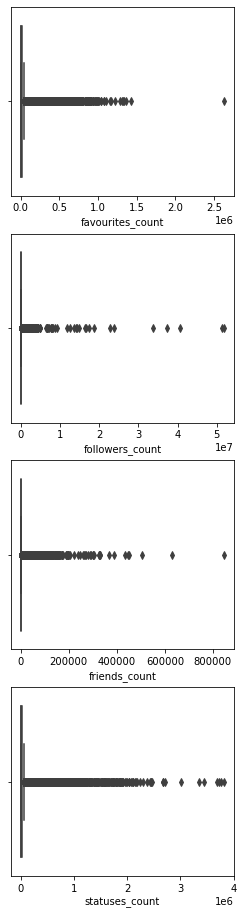

In [63]:
# Visualize twitter activity 
box_plots(unique_northwestern)

In [64]:
print("Median number of favourites = {}".format(unique_northwestern['favourites_count'].median()))
print("Median number of followers = {}".format(unique_northwestern['followers_count'].median()))
print("Median number of tweets = {}".format(unique_northwestern['statuses_count'].median()))

Median number of favourites = 4232.0
Median number of followers = 359.0
Median number of tweets = 5780.0


In [65]:
# create new summary dataframe for individual twitterers 
northwestern_unique = join_unique(northwestern_tweeters, unique_northwestern)
northwestern_unique.head()

,description,favourites_count,followers_count,friends_count,acct_created,location2,verified,statuses_count,num_tweets,percentage
screen_name,,,,,,,,,,
caribsunny,"Be who you are, Life is too short to be a phony.",3621.0,18.0,10.0,2016-04-16,NaN,False,2285,1.0,0.043764
abby_christeen,student,62.0,14.0,69.0,2017-01-20,Florida,False,1749,1.0,0.057176
JoeAguilar64,"Daily Herald Lake Cty. sports editor/reporter, also cover Blackhawks, Bears, Cubs, ABC7 Morning News contributor, hooked on golf, Ancient Aliens & craft beers",1223.0,1820.0,632.0,2013-06-28,NaN,False,4917,1.0,0.020338
Mill_TJ,Father. Husband. Loras College Head Wrestling Coach. Former Head Wrestling Coach Holy Cross School. I remember the days when I prayed for the things I have now.,556.0,205.0,290.0,2013-10-29,Dubuque,False,278,1.0,0.359712
NevinCaple,I grew up playing sports. Now I work to make athletics better. Managing Director/Co-Founder of @LGBTSportSafe and @BTScampaign. Strategic Diversity Consultant.,726.0,739.0,287.0,2013-08-25,New York,False,813,1.0,0.123001


In [177]:
# identify prolific twitterers, show those who tweet about Northwestern most frequently
northwestern_prolific = prolific(northwestern_unique)
print(len(northwestern_prolific))
print(len(northwestern_prolific)/len(northwestern_unique))
pd.DataFrame(northwestern_prolific[['num_tweets', 'statuses_count', 'percentage']]).sort_values(by='num_tweets', ascending=False)[:20]

54118
0.16060755346363642


/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_tweets,statuses_count,percentage
screen_name,,,
insidenu,997.0,54895,1.8
cfbscoresbot,806.0,114797,0.7
NorthwesternU,522.0,15404,3.4
micheleweldon,514.0,63127,0.8
sbncollege,505.0,522286,0.1
thedailynu,493.0,41271,1.2
NatsAndCats,486.0,93223,0.5
PAndres2001,483.0,86281,0.6
jmkuhn99,436.0,172667,0.3


### UIC Analysis

In [180]:
# read in UIC data 
uic_df = pd.read_csv('shared_data_kmr1_uic_df (1)')

In [181]:
uic_df = date_change(uic_df)

In [182]:
uic_df = new_location(uic_df)

In [183]:
uic_df = new_vars(uic_df)

In [184]:
print("Number of Tweets about UIC = {}".format(len(uic_df)))

Number of Tweets about UIC = 180762


In [185]:
# check cleaning of location variable 
pd.DataFrame(np.unique(uic_df['location2'].astype(str), return_counts=True)).T.sort_values(by=1, ascending=False).head(25)

,0,1
17573,nan,56393
3375,Chicago,42298
13845,United States,2303
6449,Illinois,2126
4075,Davao City,1863
9375,New York,1135
10324,Paris,1026
9229,Nashville,806
14319,Washington,633
7978,Los Angeles,497


In [75]:
# calculate retweets 
uic_retweets = pd.DataFrame(np.unique(uic_df['retweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
uic_retweets = uic_retweets.rename(columns={0:'Retweet', 1:'Count'})
uic_retweets['percentage'] = uic_retweets['Count']/len(uic_df)*100
uic_retweets = uic_retweets.set_index('Retweet')
uic_retweets

,Count,percentage
Retweet,,
True,104999,58.0869
False,75763,41.9131


In [76]:
# calculate duplicates 
uic_dup = pd.DataFrame(np.unique(uic_df['duplicate_tweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
uic_dup = uic_dup.rename(columns={0:'Duplicate', 1:'Count'})
uic_dup['percentage'] = uic_dup['Count']/len(uic_df)*100
uic_dup = uic_dup.set_index('Duplicate')
uic_dup

,Count,percentage
Duplicate,,
False,93796,51.8892
True,86966,48.1108


In [77]:
# create variable for unique twitterers 
unique_uic = unique_vars(uic_df)

In [78]:
print("Number of unique twitters = {}".format(len(unique_uic)))

Number of unique twitters = 86956


In [79]:
# aggregate location 
uic_location = location_sum(unique_uic)

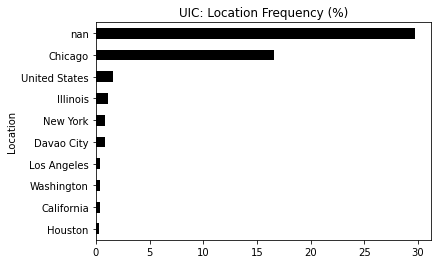

In [80]:
# visualize
ax = uic_location['percentage'].head(10).sort_values(ascending=True).plot.barh(color='black', title='UIC: Location Frequency (%)');
ax.grid(False)

In [81]:
uic_location['percentage'].head(10)

Location
nan               29.6817
Chicago           16.6187
United States     1.56056
Illinois          1.17531
New York         0.900455
Davao City       0.818805
Washington       0.430103
Los Angeles      0.430103
California       0.385252
Houston          0.326602
Name: percentage, dtype: object

In [83]:
# create df to capture tweet activity 
uic_tweeters = tweeters(uic_df, unique_uic)

In [84]:
uic_tweeters.sort_values(by='num_tweets', ascending=False)[:20]

,num_tweets,statuses_count,percentage
screen_name,,,
nan,9918.0,NaN,NaN
nashvillehhgmag,599.0,107712.0,0.556113
uic,370.0,2617.0,14.138326
ClearanceJobsVA,331.0,92115.0,0.359333
kog1,314.0,4553.0,6.896552
thisisUIC,293.0,9167.0,3.196247
mplaudUIC,278.0,2234.0,12.444047
UICnews,273.0,11183.0,2.441205
UICsoftball,263.0,8904.0,2.953729


In [86]:
# add tweet activity to unique df 
unique_uic = join_unique(uic_tweeters, unique_uic)
unique_uic.head()

,description,favourites_count,followers_count,friends_count,acct_created,location2,verified,statuses_count,num_tweets,percentage
screen_name,,,,,,,,,,
strid74,"Pizza expert, joke teller, beer maker, traveler, dad.",31.0,22.0,68.0,2009-02-23,NaN,False,67,1.0,1.492537
JDGonger517,"Hockey, Spartans, Red Sox and Student Affairs. Newly minted M Ed. Tweet alot. Totally Random.",11123.0,627.0,847.0,2009-09-28,Allendale,False,32833,1.0,0.003046
_kiaraxoxo_,jorgie💜🐘💛🌞💙🌸,8899.0,455.0,397.0,2013-12-31,NaN,False,12622,1.0,0.007923
Alex_Leddesma,views are my own,1419.0,92.0,93.0,2015-11-16,NaN,False,1841,1.0,0.054318
cranky606,"If it's here, my flamethrower is probably on. Some people know me as fenario.",1536.0,27.0,360.0,2016-02-26,Flamethrower Station,False,909,1.0,0.110011


In [87]:
print("Median number of favourites = {}".format(unique_uic['favourites_count'].median()))
print("Median number of followers = {}".format(unique_uic['followers_count'].median()))
print("Median number of tweets = {}".format(unique_uic['statuses_count'].median()))

Median number of favourites = 4888.0
Median number of followers = 377.0
Median number of tweets = 6499.5


In [89]:
# calculate number of verified users 
uic_ver = pd.DataFrame(np.unique(unique_uic['verified'].astype(bool), return_counts=True)).T
uic_ver['percent'] = uic_ver[1]/len(unique_uic)
uic_ver

,0,1,percent
0,False,85538,0.983693
1,True,1418,0.0163071


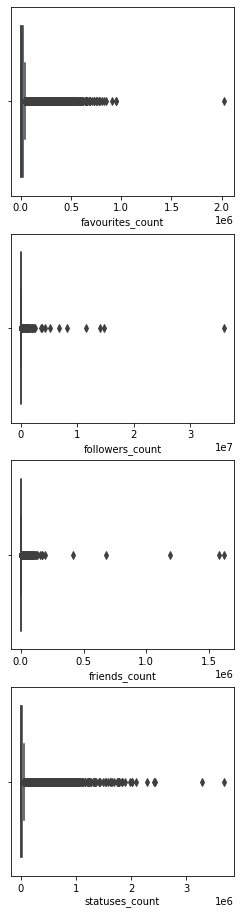

In [90]:
# visualize tweet activity 
box_plots(unique_uic)

In [178]:
# identify prolific twitterers, show those who tweet about UIC most frequently
uic_prolific = prolific(unique_uic)
print(len(uic_prolific))
print(len(uic_prolific)/len(unique_uic))
pd.DataFrame(uic_prolific[['num_tweets', 'statuses_count', 'percentage']]).sort_values(by='num_tweets', ascending=False)[:20]

13101
0.15066240397442385


/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_tweets,statuses_count,percentage
screen_name,,,
nashvillehhgmag,599.0,107712,0.6
ClearanceJobsVA,331.0,92115,0.4
UICnews,273.0,11183,2.4
uicflames,262.0,17155,1.5
cfbscoresbot,197.0,111572,0.2
prpnews,185.0,887492,0.0
purplepassion12,164.0,163329,0.1
kingLouie005,150.0,85327,0.2
dabyronicred,132.0,70812,0.2


### Depaul Analysis

In [91]:
#read in depaul data
depaul_df = pd.read_csv('shared_data_kmr1_depaul_df')

In [92]:
# change date, clean location, add new variables 
depaul_df = date_change(depaul_df)
depaul_df = new_location(depaul_df)
depaul_df = new_vars(depaul_df)

In [93]:
# length of original data 
len(depaul_df)

500890

In [94]:
# Through data exploration, noticed tweets related to depaul prep school and St. Vincent DePaul. These were filtered out 
depaul_df = depaul_df[~depaul_df['text'].str.contains('depaulprep', flags=re.IGNORECASE)]
depaul_df = depaul_df[~depaul_df['text'].str.contains('DePaul Prep', flags=re.IGNORECASE)]
depaul_df = depaul_df[~depaul_df['description'].str.contains('depaulprep', na=False, flags=re.IGNORECASE)]
depaul_df = depaul_df[~depaul_df['description'].str.contains('DePaul Prep', na=False, flags=re.IGNORECASE)]
depaul_df = depaul_df[~depaul_df['screen_name'].str.contains('depaulprep', na=False, flags=re.IGNORECASE)]
depaul_df = depaul_df[~depaul_df['text'].str.contains('St. Vincent DePaul', flags=re.I)]

In [191]:
# final depaul dataframe length
print("Mumber of tweets about Depaul = {}".format(len(depaul_df)))

Mumber of tweets about Depaul = 485527


In [192]:
depaul_df.head()

,tweet_created,text,statuses_count,quoted_status_id_str,default_profile_image,description,favourites_count,followers_count,friends_count,id_str,...,verified,time_tweet_created,time_acct_created,acct_created,location2,location3,tweet,retweet,duplicate_tweet,tweet_month
268996,2017-06-22,"Interested in a #job in #Chicago, IL? This could be a great fit: https://t.co/ereuGKhNbw #DePaulU #Finance #Hiring",33,NaN,False,"Working at DePaul University means being part of one of the nation’s largest private universities, with nearly 25,000 students.",0.0,364.0,386.0,3.282488e+09,...,False,21:04:54,14:15:51,2015-07-17,Chicago,IL,1,False,False,06/2017
329459,2017-06-22,RT @juliasarte: can't wait to cheer as a blue demon the next 4 years😭💙❤️ @DePaulAthletics @DePaulU https://t.co/ocXmrs4AzG,1061,NaN,False,curly headed cutie || GVO 💫 || #EIU20 🌸,85.0,197.0,148.0,7.563343e+17,...,False,16:44:29,03:45:20,2016-07-22,NaN,NaN,1,True,False,06/2017
329458,2017-06-22,"Interested in a #job in #Chicago, IL? This could be a great fit: https://t.co/iMTHUDNhhq #DePaulU #Clerical #Hiring",33,NaN,False,"Working at DePaul University means being part of one of the nation’s largest private universities, with nearly 25,000 students.",0.0,364.0,386.0,3.282488e+09,...,False,16:42:11,14:15:51,2015-07-17,Chicago,IL,1,False,False,06/2017
329457,2017-06-22,Summer Leadership Summit for Aspiring Directors. Hosted by DePaul Univ &amp; @mcgonag_maureen #aspiringdirectors… https://t.co/FKSu7L2d9B,911,NaN,False,"NIRSA President | Executive Director, Campus Life Services at the University of Maryland, Baltimore | ""Peace, Love, and NIRSA"" and ""Elevate Your Path""",982.0,792.0,224.0,2.473074e+09,...,False,16:31:46,21:42:57,2014-05-01,Baltimore,MD,1,False,False,06/2017
329456,2017-06-22,RT @AAIHS: Call for Applications!! Ida B. Wells-Barnett Postdoctoral Teaching Fellowship at DePaul University https://t.co/Knu1FnjO5c,11332,NaN,False,"Becoming urban (mathematics) education scholar, Spelman woman, and Christ follower. I speak & tweet for myself.",1895.0,1067.0,1376.0,1.794951e+07,...,False,16:26:51,22:40:54,2008-12-07,Madison,WI,1,True,False,06/2017


In [193]:
# calculate retweets 
depaul_retweets = pd.DataFrame(np.unique(depaul_df['retweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
depaul_retweets = depaul_retweets.rename(columns={0:'Retweet', 1:'Count'})
depaul_retweets['percentage'] = depaul_retweets['Count']/len(depaul_df)*100
depaul_retweets = depaul_retweets.set_index('Retweet')
depaul_retweets

,Count,percentage
Retweet,,
False,251111,51.7193
True,234416,48.2807


In [194]:
# calculate duplicate 
depaul_dup = pd.DataFrame(np.unique(depaul_df['duplicate_tweet'], return_counts=True)).T.sort_values(by=1, ascending=False)
depaul_dup = depaul_dup.rename(columns={0:'Duplicate', 1:'Count'})
depaul_dup['percentage'] = depaul_dup['Count']/len(depaul_df)*100
depaul_dup = depaul_dup.set_index('Duplicate')
depaul_dup

,Count,percentage
Duplicate,,
False,300693,61.9313
True,184834,38.0687


In [195]:
# create df of unique twitterers 
depaul_unique = unique_vars(depaul_df)
depaul_unique.head()

,description,favourites_count,followers_count,friends_count,screen_name,acct_created,location2,verified,statuses_count
329459,curly headed cutie || GVO 💫 || #EIU20 🌸,85.0,197.0,148.0,christianamiIan,2016-07-22,NaN,False,1061
329457,"NIRSA President | Executive Director, Campus Life Services at the University of Maryland, Baltimore | ""Peace, Love, and NIRSA"" and ""Elevate Your Path""",982.0,792.0,224.0,NIRSAPresident,2014-05-01,Baltimore,False,911
329456,"Becoming urban (mathematics) education scholar, Spelman woman, and Christ follower. I speak & tweet for myself.",1895.0,1067.0,1376.0,DrErikaBullock,2008-12-07,Madison,False,11332
326355,Brown Stallion horse with skates on Instagram: @tenderandmild,7598.0,402.0,469.0,alisonogun,2014-02-23,where you need me,False,4460
361565,smack dab in the middle of Hollyweird,10965.0,659.0,502.0,b_rodd33,2013-02-17,With Omar,False,14371


In [196]:
print("Mumber of people tweeting about Depaul = {}".format(len(depaul_unique)))

Mumber of people tweeting about Depaul = 164197


In [197]:
print("Median number of favourites = {}".format(depaul_unique['favourites_count'].median()))
print("Median number of followers = {}".format(depaul_unique['followers_count'].median()))
print("Median number of tweets = {}".format(depaul_unique['statuses_count'].median()))

Median number of favourites = 4156.0
Median number of followers = 338.0
Median number of tweets = 5468.0


In [198]:
# number of verified twitterers 
pd.DataFrame(np.unique(depaul_unique['verified'].astype(bool), return_counts=True)).T

,0,1
0,False,160873
1,True,3324


In [199]:
# create summary location df 
depaul_location = location_sum(depaul_unique)
depaul_location.head(20)

,Count,percentage
Location,,
nan,54083,32.9379
Chicago,17574,10.703
United States,4691,2.85693
New York,2044,1.24485
Illinois,1105,0.672972
Texas,947,0.576746
Los Angeles,908,0.552994
Washington,869,0.529242
California,831,0.506099


In [200]:
# create df summarizing tweet activity 
depaul_tweeters = tweeters(depaul_df, depaul_unique)
depaul_tweeters.head(20)

,num_tweets,statuses_count,percentage
screen_name,,,
nan,28730.0,NaN,NaN
DePaulUJobs,11256.0,19.0,59242.105263
samseles,2020.0,22782.0,8.866649
DePauliaSports,1755.0,15955.0,10.999687
kreyme8,1670.0,6024.0,27.722444
DePaulNewsroom,1417.0,13456.0,10.530618
1pantF,1313.0,17299.0,7.590034
Soxbluto,1296.0,33524.0,3.865887
DePaulU,1202.0,25841.0,4.651523


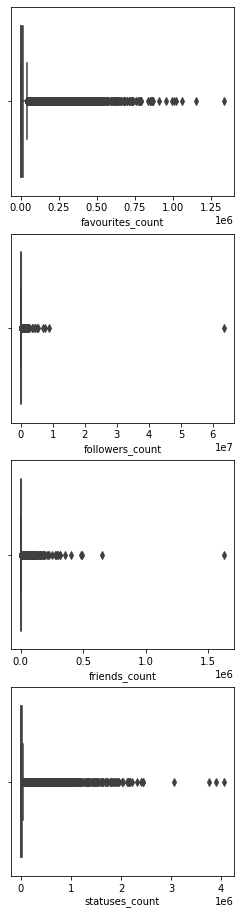

In [201]:
# visualize activity 
box_plots(depaul_unique)

In [202]:
# create one df with info about unique twitterers 
depaul_unique = join_unique(depaul_tweeters, depaul_unique)
depaul_unique.head()

,description,favourites_count,followers_count,friends_count,acct_created,location2,verified,statuses_count,num_tweets,percentage
screen_name,,,,,,,,,,
christianamiIan,curly headed cutie || GVO 💫 || #EIU20 🌸,85.0,197.0,148.0,2016-07-22,NaN,False,1061,1.0,0.094251
NIRSAPresident,"NIRSA President | Executive Director, Campus Life Services at the University of Maryland, Baltimore | ""Peace, Love, and NIRSA"" and ""Elevate Your Path""",982.0,792.0,224.0,2014-05-01,Baltimore,False,911,1.0,0.109769
DrErikaBullock,"Becoming urban (mathematics) education scholar, Spelman woman, and Christ follower. I speak & tweet for myself.",1895.0,1067.0,1376.0,2008-12-07,Madison,False,11332,1.0,0.008825
alisonogun,Brown Stallion horse with skates on Instagram: @tenderandmild,7598.0,402.0,469.0,2014-02-23,where you need me,False,4460,1.0,0.022422
b_rodd33,smack dab in the middle of Hollyweird,10965.0,659.0,502.0,2013-02-17,With Omar,False,14371,1.0,0.006958


In [203]:
# identify prolific twitterers, show those who tweet about Northwestern most frequently
depaul_prolific = prolific(depaul_unique)
print(len(depaul_prolific))
print(len(depaul_prolific)/len(depaul_unique))
pd.DataFrame(depaul_prolific[['num_tweets', 'statuses_count', 'percentage']]).sort_values(by='num_tweets', ascending=False)[:20]


23494
0.14308422200162


/Users/kylaronellenfitsch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_tweets,statuses_count,percentage
screen_name,,,
samseles,2020.0,22782,8.9
DePaulU,1202.0,25841,4.7
groovatron2000,932.0,66037,1.4
becb_sbn,923.0,79770,1.2
BigNorthConBNC,821.0,155524,0.5
CoachDougBruno,733.0,9610,7.6
EliHershkovich,658.0,28043,2.3
NotHotTakes,511.0,71124,0.7
Ericslosingit,498.0,58503,0.9


### Comparative Analysis

In [204]:
# create new dataframe aggregating percentage of twitters living in each city (for each university )
sum_location1 = uchicago_location.join(uic_location, lsuffix='_uc', rsuffix='_uic', how='outer').sort_values(by='Count_uc', ascending=False)
sum_location2 = depaul_location.join(northwestern_location, lsuffix='_d', rsuffix='_n', how='outer')
sum_location = sum_location1.join(sum_location2, how='outer')
sum_location = sum_location[['percentage_uc','percentage_n','percentage_uic','percentage_d']]
sum_location.columns = ['UChicago','Northwestern','UIC','Depaul']

In [205]:
sum_location = sum_location.sort_values(by='UChicago', ascending=False)
sum_location = sum_location.drop('nan')
sum_location.head(10)

,UChicago,Northwestern,UIC,Depaul
Location,,,,
Chicago,6.66192,4.78902,16.6187,10.703
United States,2.50744,2.37329,1.56056,2.85693
New York,2.0254,1.60613,0.900455,1.24485
Washington,1.19387,0.922667,0.430103,0.529242
Los Angeles,0.81408,0.695339,0.430103,0.552994
London,0.723943,0.407469,0.248401,0.263708
California,0.688672,0.495908,0.385252,0.506099
Texas,0.494148,0.608384,0.202401,0.576746
Boston,0.453533,0.386992,0.197801,0.23082


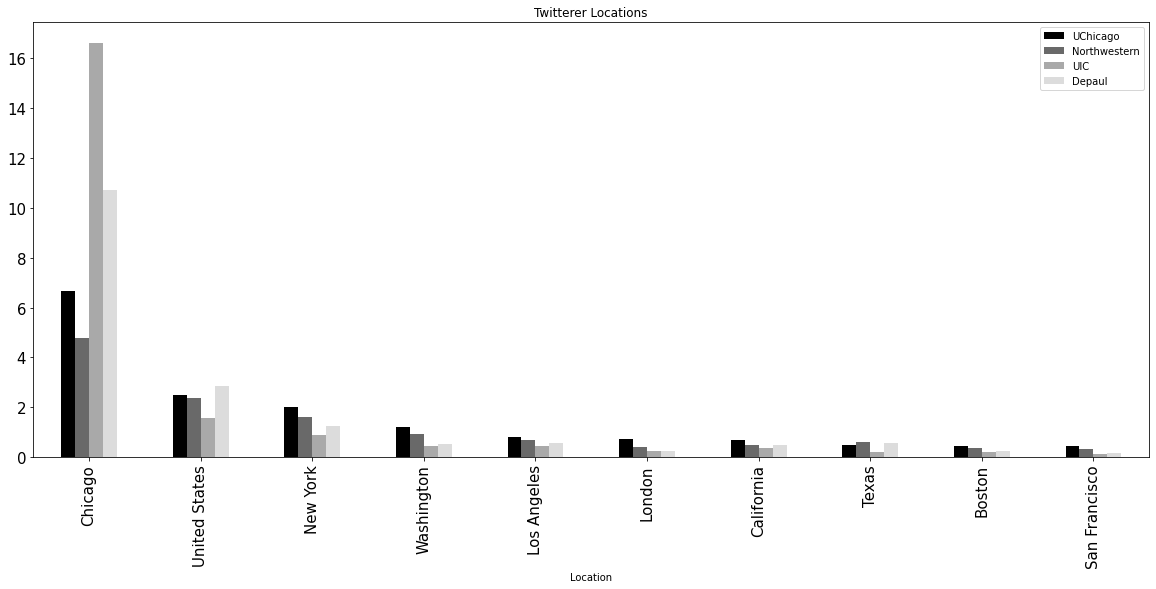

In [206]:
# Create bar chart. Note much greater local twitter activity for UIC and DePaul
colors = ['black','dimgrey','darkgrey','gainsboro']

ax = sum_location[:10].sort_values(by='UChicago',ascending=False).plot.bar(figsize=(20,8), 
                                                                           color=colors, 
                                                                           title='Twitterer Locations',
                                                                           fontsize=15);
ax.grid(False)

In [207]:
# create dataframes with twitter traffic aggregated monthly 
uchicago_month = tweet_month(uchicago_df).rename(columns={'tweet':'UChicago'})
northwestern_month = tweet_month(northwestern_df).rename(columns={'tweet':'Northwestern'})
uic_month = tweet_month(uic_df).rename(columns={'tweet':'UIC'})
depaul_month = tweet_month(depaul_df).rename(columns={'tweet':'Depaul'})

In [208]:
# create one summary table 
sum_month1 = uchicago_month.join(northwestern_month)
sum_month2 = uic_month.join(depaul_month)
sum_month = sum_month1.join(sum_month2)
sum_month.index = pd.to_datetime(sum_month.index)
sum_month = sum_month.sort_index()

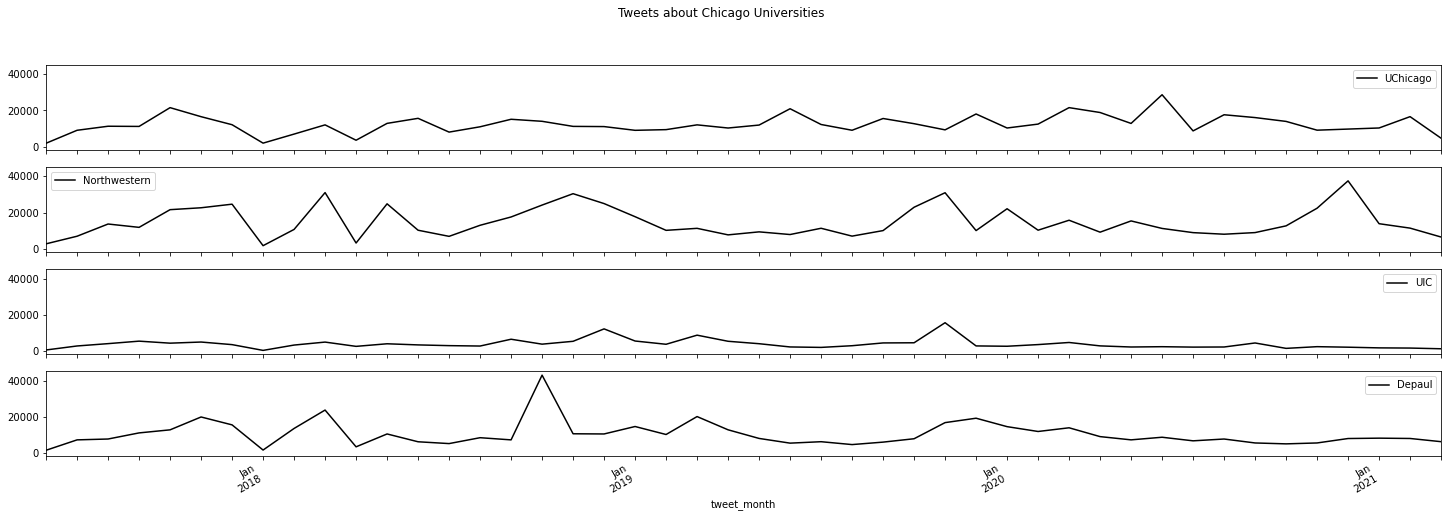

In [209]:
# visualize results for each university 
ax = sum_month.plot(subplots=True, 
                    title='Tweets about Chicago Universities', 
                    figsize=(25,8), 
                    color='black', 
                    sharey=True, 
                    grid=False, 
                    xticks=sum_month.index
                   );

In [210]:
# find month with greatest activity for UChicago
sum_month[sum_month['UChicago'] == sum_month['UChicago'].max()]

,UChicago,Northwestern,UIC,Depaul
tweet_month,,,,
2020-06-01,28674,11318,2458,8864


In [211]:
# explore retweets for that time period 
uchicago_df[(uchicago_df['tweet_month'] == '06/2020') & (uchicago_df['duplicate_tweet'] == True)]['text'][:5]

563858    RT @tyler_okeke: organized a mass email campaign w/ @noahbball1, @_julieofficial &amp; @beatanazi to cancel finals @UChicago! we have two templ…
563859         RT @RaychJackson: white people frazzled by the protest in Hyde Park like University of Chicago didn’t expand in black neighborhoods in the…
568722     RT @cameronks: “Avoiding intubation is key” —&gt; UChicago Medicine doctors see 'truly remarkable' success using ventilator alternatives to tr…
563846        RT @Si2mEN: A lot of my UChicago/NU friends in to the workforce need to realize that when you work for these big 4 consulting firms and lar…
563847        RT @princessmlokhia: So UChicago couldnt afford to lower tuition this quarter but they can afford to arm their private police force with te…
Name: text, dtype: object

In [212]:
# find month with greatest spike for Northwestern
sum_month[sum_month['Northwestern'] == sum_month['Northwestern'].max()]

,UChicago,Northwestern,UIC,Depaul
tweet_month,,,,
2020-12-01,9764,37515,2182,8160


In [213]:
# explore retweets 
northwestern_df[(northwestern_df['tweet_month'] == '12/2020') & (northwestern_df['duplicate_tweet'] == True)]['text'][:5]

1293108            RT @XwaveTech: Northwestern University Has Developed An AI System That Helps Detect Covid-19 On Chest X-Rays https://t.co/RA2WAdaR0Z
1293125    RT @ESPNRittenberg: Sources: The #Northwestern-#Minnesota game set for Saturday in Minneapolis is expected to be canceled because of ongoin…
1293117    RT @BioSoft_Inc: @NorthwesternU researchers have developed a new artificial intelligence (A.I.) platform that detects #COVID__19 by analyzi…
1293118    RT @BioSoft_Inc: @NorthwesternU researchers have developed a new artificial intelligence (A.I.) platform that detects COVID-19 by analyzing…
1293120    RT @Forbes: Northwestern University has developed an AI system that helps detect Covid-19 on chest X-rays https://t.co/v0VzDHAUBD https://t…
Name: text, dtype: object

In [214]:
# find greatest spike for UIC
sum_month[sum_month['UIC'] == sum_month['UIC'].max()]

,UChicago,Northwestern,UIC,Depaul
tweet_month,,,,
2019-11-01,9334,30974,15661,16918


In [215]:
# explore retweets 
uic_df[(uic_df['tweet_month'] == '11/2019') & (uic_df['duplicate_tweet'] == True)]['text'][:5]

155563    RT @Some1TouleenOn: Donald dipshit hates Chicago because we protested so hard when he was trying to rally at the UIC Pavilion, that shit go…
155562    RT @Some1TouleenOn: Donald dipshit hates Chicago because we protested so hard when he was trying to rally at the UIC Pavilion, that shit go…
155566    RT @Some1TouleenOn: Donald dipshit hates Chicago because we protested so hard when he was trying to rally at the UIC Pavilion, that shit go…
111301     RT @aliemahb: I’m proud to stand with the students organizing #AntiBlackISU. UIC also has a lot of work to do, and I look forward to those…
111300     RT @aliemahb: I’m proud to stand with the students organizing #AntiBlackISU. UIC also has a lot of work to do, and I look forward to those…
Name: text, dtype: object

In [216]:
# identify greatest spike for depaul 
sum_month[sum_month['Depaul'] == sum_month['Depaul'].max()]

,UChicago,Northwestern,UIC,Depaul
tweet_month,,,,
2018-10-01,14044,24181,3857,43053


In [217]:
# explore time period 
depaul_df[(depaul_df['tweet_month'] == '10/2018') & (depaul_df['duplicate_tweet'] == True)]['text'][:5]

218393            RT @slwalter123: Glad to be working with our partners in @StudioChiDePaul on this new program @dpulibrarian https://t.co/uCTyFCZse6
311772    RT @AndrewKoobHS: BIG hit by JJ Scocco on first down. SPP starting to stack momentum and now DePaul facing a 2nd and 17 after spending its…
166186                                                                       RPI land mines: Providence (221),  DePaul x2 (239), Seton Hall x2 (211).
395679    RT @DepaulIreland: Did you know there over 100 homeless persons over the age of 65 in Ireland according to the latest #Homeless figures-at…
98753                                                               RT @GrantWeinmann: DePaul not getting their money's worth https://t.co/FKdG3uFI7X
Name: text, dtype: object

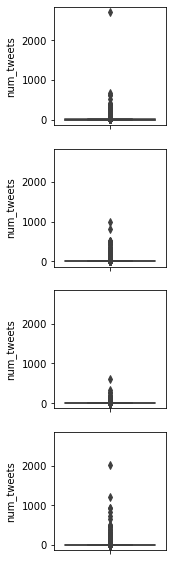

In [219]:
# visualize number of tweets for prolific twitterers 
f, axes = plt.subplots(4, 1, sharey=True)
sns.boxplot(y="num_tweets", data=uchicago_prolific, ax=axes[0])
sns.boxplot(y="num_tweets", data=northwestern_prolific, ax=axes[1])
sns.boxplot(y="num_tweets", data=uic_prolific, ax=axes[2])
sns.boxplot(y="num_tweets", data=depaul_prolific, ax=axes[3])
f.set_size_inches(2, 10)